In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import TextVectorization
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from helper_functions import calculate_results
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import string
import tensorflow_hub as hub

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


In [4]:
# run this if you have to use 200k dataset
# import zipfile
# with zipfile.ZipFile(r'/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign')

In [5]:
# change data_dir accordingly if you want to use 200k dataset.
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [6]:
filenames = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [7]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [8]:
train_lines = get_lines(data_dir + '/train.txt')

In [9]:
len(train_lines)

210040

In [10]:
def preprocess_text_with_line_numbers(filename):

  dict_list = []
  temp_dict = {}
  temp_list = []
  line_number = 0

  text_lines = get_lines(filename)

  for line in text_lines:
    if line.startswith("###"):
      continue
    if line.startswith("\n"):
      for temp in temp_list:
        temp['total_lines'] = line_number - 1
      dict_list.extend(temp_list)
      temp_list = []
      line_number = 0
      continue
    tab = line.index('\t')
    temp_dict['line_number'] = line_number
    temp_dict['target'] = line[:tab]
    temp_dict['text'] = line[tab+1:-1].lower()
    temp_list.append(temp_dict)
    line_number += 1
    temp_dict = {}

  return dict_list
    
  

In [11]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'/train.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'/test.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'/dev.txt')

CPU times: user 306 ms, sys: 88.8 ms, total: 395 ms
Wall time: 404 ms


In [12]:
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

In [13]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


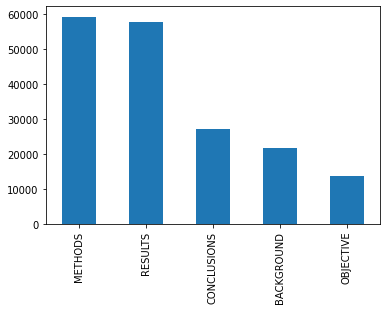

In [15]:
train_df.target.value_counts().plot.bar()

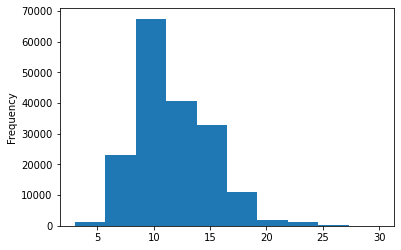

In [16]:
train_df.total_lines.plot.hist()

In [17]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [18]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [20]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [22]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [23]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [24]:
text_vectorizer = TextVectorization(output_sequence_length = output_seq_len,
                                    output_mode = 'int',
                                    )

In [25]:
text_vectorizer.adapt(train_sentences)

In [26]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab)

64841

In [27]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': None,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [28]:
token_embed = layers.Embedding(input_dim=len(words_in_vocab),
                             output_dim=128,
                             input_length=output_seq_len,
                             mask_zero=True,
                             name="token_embedding")

In [29]:
def split_chars(text):
  return " ".join(list(text))

In [30]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [31]:
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [32]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

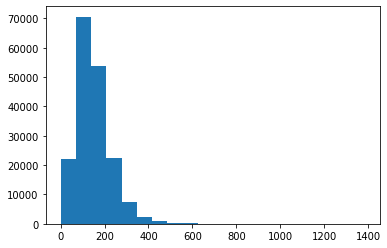

In [33]:
plt.hist(char_lens, bins=20);

In [34]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [35]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer',
                                    )


In [37]:
char_vectorizer.adapt(train_chars)

In [38]:
char_vocab = char_vectorizer.get_vocabulary()

In [39]:
char_vocab[:5], len(char_vocab)

(['', '[UNK]', 'e', 't', 'i'], 28)

In [40]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim = 25,
                              mask_zero=True,
                              name='char_embed')

In [41]:
char_embed(char_vectorizer([train_chars[0]]))

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[-0.02159917, -0.03532573, -0.02546506, ...,  0.00217551,
         -0.01361478,  0.04446831],
        [-0.02706333, -0.02889549, -0.04199759, ..., -0.00525997,
         -0.02625545, -0.00017587],
        [-0.02315423,  0.02462437,  0.00157576, ..., -0.03593404,
         -0.00562155,  0.00340407],
        ...,
        [ 0.02262921, -0.01060098, -0.00128663, ..., -0.03859922,
          0.04399845, -0.02380936],
        [ 0.02262921, -0.01060098, -0.00128663, ..., -0.03859922,
          0.04399845, -0.02380936],
        [ 0.02262921, -0.01060098, -0.00128663, ..., -0.03859922,
          0.04399845, -0.02380936]]], dtype=float32)>

In [42]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


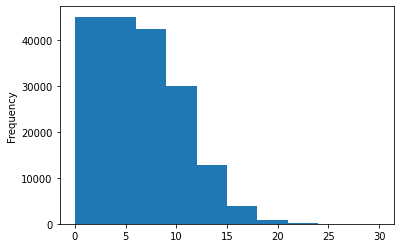

In [43]:
train_df.line_number.plot.hist()

In [44]:
train_df.line_number.quantile(0.98)

15.0

In [45]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)


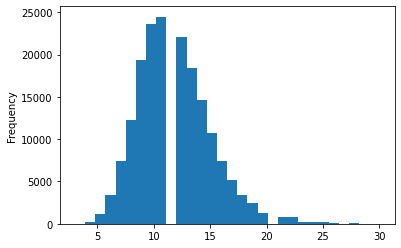

In [46]:
train_df.total_lines.plot.hist(bins=30)

In [47]:
train_df.total_lines.quantile(0.98)

20.0

In [48]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)


In [49]:
train_total_lines_one_hot.shape, train_line_numbers_one_hot.shape

(TensorShape([180040, 20]), TensorShape([180040, 15]))

In [50]:
train_line_num_tot_lines_one_hot = layers.Concatenate(name='train_line_num_tot_lines')([train_line_numbers_one_hot,train_total_lines_one_hot])
val_line_num_tot_lines_one_hot = layers.Concatenate(name='val_line_num_tot_lines')([val_line_numbers_one_hot, val_total_lines_one_hot])
test_line_num_tot_lines_one_hot = layers.Concatenate(name='test_line_num_tot_lines')([test_line_numbers_one_hot, test_total_lines_one_hot])
train_line_num_tot_lines_one_hot.shape, val_line_num_tot_lines_one_hot.shape, test_line_num_tot_lines_one_hot.shape

(TensorShape([180040, 35]), TensorShape([30212, 35]), TensorShape([30135, 35]))

In [51]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [52]:
token_inputs = layers.Input(shape=[], dtype='string', name='token_char_concat')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

char_inputs = layers.Input(shape=(1, ), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


line_number_total_lines_inputs = layers.Input(shape=(35,), dtype=tf.float32, name='line_number_total_lines_inputs')
x = layers.Dense(32, activation='relu')(line_number_total_lines_inputs)
line_number_total_lines_model = tf.keras.Model(inputs=line_number_total_lines_inputs,
                                               outputs=x)



combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output, char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
combined_output = layers.Dropout(0.5)(z)

tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_total_lines_model.output, combined_output])

output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

model = tf.keras.Model(inputs=[line_number_total_lines_model.input, token_model.input, char_model.input], outputs=output_layer, name='tribrid_embedding_model')


In [53]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_num_tot_lines_one_hot, train_sentences, train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.cache()
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [54]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_num_tot_lines_one_hot, val_sentences, val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [55]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
                optimizer='adam',
                metrics=['accuracy'])

In [56]:
history = model.fit(train_char_token_pos_dataset,
            epochs=10,
            # steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
            validation_data=val_char_token_pos_dataset,
            # validation_steps=int(0.1*len(val_char_token_pos_dataset))
            )

Epoch 1/10
5627/5627 [==============================] - 289s 49ms/step - loss: 0.9405 - accuracy: 0.8327 - val_loss: 0.8919 - val_accuracy: 0.8595
Epoch 2/10
5627/5627 [==============================] - 269s 48ms/step - loss: 0.8911 - accuracy: 0.8658 - val_loss: 0.8814 - val_accuracy: 0.8657
Epoch 3/10
5627/5627 [==============================] - 270s 48ms/step - loss: 0.8792 - accuracy: 0.8734 - val_loss: 0.8788 - val_accuracy: 0.8686
Epoch 4/10
5627/5627 [==============================] - 268s 48ms/step - loss: 0.8711 - accuracy: 0.8796 - val_loss: 0.8798 - val_accuracy: 0.8667
Epoch 5/10
5627/5627 [==============================] - 267s 48ms/step - loss: 0.8648 - accuracy: 0.8841 - val_loss: 0.8795 - val_accuracy: 0.8668
Epoch 6/10
5627/5627 [==============================] - 266s 47ms/step - loss: 0.8597 - accuracy: 0.8881 - val_loss: 0.8814 - val_accuracy: 0.8651
Epoch 7/10
5627/5627 [==============================] - 266s 47ms/step - loss: 0.8556 - accuracy: 0.8914 - val_loss: 0

In [57]:
model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.8864 - accuracy: 0.8626


[0.8864070773124695, 0.8626042604446411]

In [58]:
model_pred_probs = model.predict(val_char_token_pos_dataset)
model_pred_probs

945/945 [==============================] - 23s 21ms/step


array([[0.6675105 , 0.06736732, 0.02281622, 0.22811398, 0.01419196],
       [0.6182052 , 0.06805668, 0.05432528, 0.23055196, 0.02886093],
       [0.36776018, 0.08326073, 0.02397524, 0.48598137, 0.03902239],
       ...,
       [0.01902142, 0.10364757, 0.0210555 , 0.02862029, 0.8276552 ],
       [0.02230261, 0.57324594, 0.03007769, 0.02242969, 0.35194412],
       [0.04312002, 0.8721979 , 0.03257382, 0.0231258 , 0.02898232]],
      dtype=float32)

In [59]:
model_preds = tf.argmax(model_pred_probs, axis = 1)

In [60]:
model_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_preds)
model_results

{'accuracy': 86.26042632066728,
 'precision': 0.863401619060948,
 'recall': 0.8626042632066728,
 'f1': 0.8600907225388591}

In [61]:
model.get_layer('universal_sentence_encoder').trainable = True

In [74]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                metrics=['accuracy'])

In [75]:
history = model.fit(train_char_token_pos_dataset,
            epochs=1,
            # steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
            validation_data=val_char_token_pos_dataset,
            # validation_steps=int(0.1*len(val_char_token_pos_dataset))
            )

5627/5627 [==============================] - 1061s 186ms/step - loss: 0.7770 - accuracy: 0.9445 - val_loss: 0.8821 - val_accuracy: 0.8679


In [76]:
model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.8821 - accuracy: 0.8679


[0.882138192653656, 0.8679001927375793]

In [77]:
model_pred_probs =model.predict(val_char_token_pos_dataset)
model_pred_probs

945/945 [==============================] - 23s 22ms/step


array([[0.6939348 , 0.0648744 , 0.02821656, 0.19337466, 0.01959957],
       [0.6543677 , 0.06368162, 0.04877729, 0.20374455, 0.02942887],
       [0.3100075 , 0.07043233, 0.03483089, 0.5260263 , 0.05870297],
       ...,
       [0.02862587, 0.12710714, 0.03738593, 0.03855329, 0.7683278 ],
       [0.0347319 , 0.6069364 , 0.04037449, 0.03630683, 0.2816504 ],
       [0.05221425, 0.8859323 , 0.01635796, 0.02622593, 0.01926952]],
      dtype=float32)

In [78]:
model_preds = tf.argmax(model_pred_probs, axis = 1)

In [79]:
model_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_preds)


In [80]:
model_results

{'accuracy': 86.79001721170397,
 'precision': 0.870522312066755,
 'recall': 0.8679001721170396,
 'f1': 0.8659437113287834}

In [81]:
model.save('abstract_simplifier')